In [ ]:
# ---------------------------
# XGBoost Model Improvement with CV + Hyperparameter Tuning
# ---------------------------

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("/content/final_nova_dataset_65_35.csv")

# Target
target = 'nova_score'
drop_cols = ['worker_id', 'week', 'nova_prev_score', target]
X = df.drop(columns=drop_cols)
y = df[target]

# One-hot encode categoricals (needed for your old XGBoost version)
categorical_features = ['gender', 'region', 'partner_tier', 'worker_type']
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# ---------------------------
# Parameter search space
# ---------------------------
params = {
    "objective": "reg:squarederror",
    "eta": 0.03,             # learning rate
    "max_depth": 6,          # tree depth
    "subsample": 0.8,        # row sampling
    "colsample_bytree": 0.8, # feature sampling
    "lambda": 1.0,           # L2 reg
    "alpha": 0.0,            # L1 reg
    "eval_metric": "rmse",
    "seed": 42
}

# ---------------------------
# Cross-validation for best boosting round
# ---------------------------
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=8000,
    nfold=5,
    early_stopping_rounds=50,
    verbose_eval=200,
    seed=42
)

best_num_boost_round = len(cv_results)
print(f"Best boosting round: {best_num_boost_round}")

# ---------------------------
# Train final model with tuned rounds
# ---------------------------
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=50,
    verbose_eval=100
)

# Predict
y_pred = model.predict(dtest)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nFinal RMSE on test set: {rmse:.4f}")
print(f"Final R² on test set: {r2:.4f}")

# Feature importance
importance_dict = model.get_score(importance_type="weight")
importance_df = pd.DataFrame({
    "feature": list(importance_dict.keys()),
    "importance": list(importance_dict.values())
}).sort_values(by="importance", ascending=False)

print("\nFeature Importances:")
print(importance_df)


[0]	train-rmse:10.99988+0.02325	test-rmse:11.00582+0.09247


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("/content/final_nova_dataset_65_35.csv")

# Target
target = "nova_score"

# Drop ID/time & leakage columns
drop_cols = ["worker_id", "week", "nova_prev_score", target]
X = df.drop(columns=drop_cols)
y = df[target]

# Identify categorical features
categorical_features = ["gender", "region", "partner_tier", "worker_type"]

# Convert to category dtype for LightGBM
for col in categorical_features:
    X[col] = X[col].astype("category")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature=categorical_features)

# LightGBM parameters
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.03,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "max_depth": -1,
    "seed": 42,
    "verbose": -1
}

# Use callbacks for early stopping
callbacks = [
    lgb.early_stopping(stopping_rounds=100, verbose=True),
    lgb.log_evaluation(period=200)
]

# Train model
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=["train", "eval"],
    num_boost_round=5000,
    callbacks=callbacks
)

# Predict
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n✅ RMSE on test set: {rmse:.4f}")
print(f"✅ R2 Score on test set: {r2:.4f}")

# Feature importance
importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importance(importance_type="gain")
}).sort_values(by="importance", ascending=False)

print("\nFeature Importances:")
print(importance_df)


Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 5.69333	eval's rmse: 6.11293
[400]	train's rmse: 5.04207	eval's rmse: 5.76574
[600]	train's rmse: 4.5515	eval's rmse: 5.53205
[800]	train's rmse: 4.23569	eval's rmse: 5.44947
[1000]	train's rmse: 3.91825	eval's rmse: 5.35044
[1200]	train's rmse: 3.64847	eval's rmse: 5.26747
[1400]	train's rmse: 3.4495	eval's rmse: 5.23995
[1600]	train's rmse: 3.24485	eval's rmse: 5.21031
[1800]	train's rmse: 3.05219	eval's rmse: 5.16346
[2000]	train's rmse: 2.86695	eval's rmse: 5.11422
[2200]	train's rmse: 2.70566	eval's rmse: 5.08702
[2400]	train's rmse: 2.57393	eval's rmse: 5.08187
Early stopping, best iteration is:
[2305]	train's rmse: 2.63543	eval's rmse: 5.08163

✅ RMSE on test set: 5.0816
✅ R2 Score on test set: 0.7853

Feature Importances:
                 feature    importance
5               earnings  1.224138e+07
8          avg_job_value  3.411614e+06
0                    age  2.255133e+06
4            worker_ty

In [ ]:
# ---------------------------
# Project Nova: Fairness Evaluation
# ---------------------------

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("/content/final_nova_dataset_65_35.csv")

# Target & Features
target = "nova_score"
drop_cols = ["worker_id", "week", "nova_prev_score", target]
X = df.drop(columns=drop_cols)
y = df[target]

# Categorical features
cat_features = ["gender", "region", "partner_tier", "worker_type"]

for col in cat_features:
    X[col] = X[col].astype("category")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Prepare datasets for LightGBM
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Params
params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 63,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42
}

# Train
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=5000,
    valid_sets=[lgb_train, lgb_test],
    valid_names=["train", "eval"],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# Predict
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# ---------------------------
# FAIRNESS ANALYSIS
# ---------------------------

results = X_test.copy()
results["true_score"] = y_test.values
results["pred_score"] = y_pred

# Define sensitive groups
sensitive_features = ["gender", "region", "partner_tier"]

fairness_metrics = {}

for feat in sensitive_features:
    print(f"\n=== Fairness Analysis by {feat} ===")
    group_stats = results.groupby(feat).apply(
        lambda g: pd.Series({
            "count": len(g),
            "mean_true": g["true_score"].mean(),
            "mean_pred": g["pred_score"].mean(),
            "rmse": np.sqrt(mean_squared_error(g["true_score"], g["pred_score"])),
            "r2": r2_score(g["true_score"], g["pred_score"])
        })
    )
    fairness_metrics[feat] = group_stats
    print(group_stats)

# Combine into single report
print("\n\n=== Fairness Summary ===")
for feat, stats in fairness_metrics.items():
    print(f"\n{feat} performance:")
    print(stats)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3690]	train's rmse: 2.36426	eval's rmse: 4.96627

=== Fairness Analysis by gender ===
         count  mean_true  mean_pred      rmse        r2
gender                                                  
F       1636.0  71.864046  71.753098  5.241686  0.805785
M       2168.0  72.215551  72.238527  4.754613  0.784340
Other     22.0  77.360932  75.788781  4.284197  0.507862

=== Fairness Analysis by region ===
         count  mean_true  mean_pred      rmse        r2
region                                                  
East    1016.0  72.179443  72.188440  4.896991  0.757618
North   1201.0  71.892831  72.073712  4.742436  0.822544
South    863.0  72.338083  71.831553  5.511408  0.800902
West     746.0  72.023408  72.083022  4.741889  0.778532

=== Fairness Analysis by partner_tier ===
               count  mean_true  mean_pred      rmse        r2
partner_tier                                  

/tmp/ipython-input-4074953615.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = results.groupby(feat).apply(
/tmp/ipython-input-4074953615.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_stats = results.groupby(feat).apply(
/tmp/ipython-input-4074953615.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence th

In [ ]:
# =============================
# Project Nova - LightGBM + Fairness Evaluation
# =============================

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# ---------------------------
# 1. Load Dataset
# ---------------------------
df = pd.read_csv("/content/final_nova_dataset_65_35.csv")

# Define target and features
y = df["nova_score"]
X = df.drop(columns=["nova_score","worker_id", "nova_prev_score","week"])

# Keep raw copy for fairness evaluation
X_raw = X.copy()

# ---------------------------
# 2. Train/Test Split
# ---------------------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

# One-hot encode categorical features
X_train = pd.get_dummies(X_train_raw, drop_first=True)
X_test = pd.get_dummies(X_test_raw, drop_first=True)

# Align train/test columns
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# ---------------------------
# 3. Train LightGBM Model
# ---------------------------
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,        # keep it small for stability
    "num_leaves": 31,             # smaller = less complex trees
    "max_depth": -1,              # let LGBM decide, but num_leaves controls complexity
    "lambda_l1": 0.1,             # L1 regularization
    "lambda_l2": 1.0,             # L2 regularization
    "min_data_in_leaf": 50,       # minimum samples per leaf
    "feature_fraction": 0.8,      # randomly sample 80% features per iteration
    "bagging_fraction": 0.8,      # randomly sample 80% data per iteration
    "bagging_freq": 5,            # perform bagging every 5 iterations
    "verbosity": -1
}

from lightgbm import early_stopping, log_evaluation

print("Training LightGBM...")
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "eval"],
    num_boost_round=5000,
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(200)
    ]
)


# ---------------------------
# 4. Model Evaluation
# ---------------------------
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)   # instead of squared=False
r2 = r2_score(y_test, y_pred)

print(f"RMSE on test set: {rmse:.4f}")
print(f"R² on test set: {r2:.4f}")

# ---------------------------
# 5. Fairness Evaluation
# ---------------------------
results = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred,
    "gender": X_test_raw["gender"].values,
    "region": X_test_raw["region"].values,
    "partner_tier": X_test_raw["partner_tier"].values
})

def fairness_eval(df, group_col):
    group_stats = df.groupby(group_col).apply(
        lambda g: pd.Series({
            "count": len(g),
            "mean_true": g["y_true"].mean(),
            "mean_pred": g["y_pred"].mean(),
            "rmse": np.sqrt(mean_squared_error(g["y_true"], g["y_pred"])),
            "r2": r2_score(g["y_true"], g["y_pred"]) if len(g) > 1 else np.nan
        })
    )
    return group_stats

print("\n=== Fairness Analysis by gender ===")
print(fairness_eval(results, "gender"))

print("\n=== Fairness Analysis by region ===")
print(fairness_eval(results, "region"))

print("\n=== Fairness Analysis by partner_tier ===")
print(fairness_eval(results, "partner_tier"))

# ---------------------------
# 6. Feature Importance
# ---------------------------
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importance()
}).sort_values(by="importance", ascending=False)

print("\nTop 15 Feature Importances:")
print(importances.head(15))

Training LightGBM...
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 6.91898	eval's rmse: 7.01622
[400]	train's rmse: 6.27666	eval's rmse: 6.5196
[600]	train's rmse: 5.88175	eval's rmse: 6.24112
[800]	train's rmse: 5.60527	eval's rmse: 6.06553
[1000]	train's rmse: 5.38589	eval's rmse: 5.92469
[1200]	train's rmse: 5.20728	eval's rmse: 5.83335
[1400]	train's rmse: 5.03728	eval's rmse: 5.74154
[1600]	train's rmse: 4.86277	eval's rmse: 5.63269
[1800]	train's rmse: 4.72544	eval's rmse: 5.56993
[2000]	train's rmse: 4.61591	eval's rmse: 5.53762
[2200]	train's rmse: 4.49566	eval's rmse: 5.48699
[2400]	train's rmse: 4.39883	eval's rmse: 5.45965
[2600]	train's rmse: 4.30891	eval's rmse: 5.43769
[2800]	train's rmse: 4.21825	eval's rmse: 5.41328
[3000]	train's rmse: 4.1386	eval's rmse: 5.40261
[3200]	train's rmse: 4.05929	eval's rmse: 5.38823
[3400]	train's rmse: 3.98166	eval's rmse: 5.36835
[3600]	train's rmse: 3.90608	eval's rmse: 5.35056
[3800]	train's rmse: 3.

/tmp/ipython-input-2383215911.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_stats = df.groupby(group_col).apply(
/tmp/ipython-input-2383215911.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_stats = df.groupby(group_col).apply(
/tmp/ipython-input-2383215911.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut

In [ ]:
import joblib

# Save the trained model and features
joblib.dump(model, "nova_lightgbm.pkl")
joblib.dump(X_train.columns, "nova_lightgbm_features.pkl")


['nova_lightgbm_features.pkl']

In [ ]:
import pandas as pd
import joblib

# Load model + features
model = joblib.load("nova_lightgbm.pkl")
features = joblib.load("nova_lightgbm_features.pkl")

# Load new dataset
new_df = pd.read_csv("/content/catboost_predicted_score.csv")
# print(new_df.head())
# Preprocess new dataset
X_new = pd.get_dummies(new_df, drop_first=True)
X_new = X_new.reindex(columns=features, fill_value=0)

# Predict
y_new_pred = model.predict(X_new, num_iteration=model.best_iteration)

# Attach predictions back to dataset
new_df["light_gbm_predicted_score"] = y_new_pred

output_path = "/content/lightgbm_and_catboost_predicted_score.csv"
new_df.to_csv(output_path, index=False)
print(new_df.head())



   worker_id  week  age gender region partner_tier worker_type  earnings  \
0          0     4   33      M  North       silver    merchant   1416.67   
1          0     5   33      M  North       silver    merchant   1486.81   
2          0     6   33      M  North       silver    merchant   1608.10   
3          0     7   33      M  North       silver    merchant   1498.12   
4          0     8   33      M  North       silver    merchant   1779.19   

   jobs_completed  repeat_client_share  ...  tips_share  customer_rating  \
0               7                 0.93  ...        0.26         4.916885   
1              12                 0.39  ...        0.19         4.529594   
2              14                 0.22  ...        0.14         2.103355   
3               8                 0.18  ...        0.16         3.917451   
4              11                 0.37  ...        0.35         4.457018   

   cancellation_rate  peak_hour_jobs_share  transaction_count  gap_days  \
0          

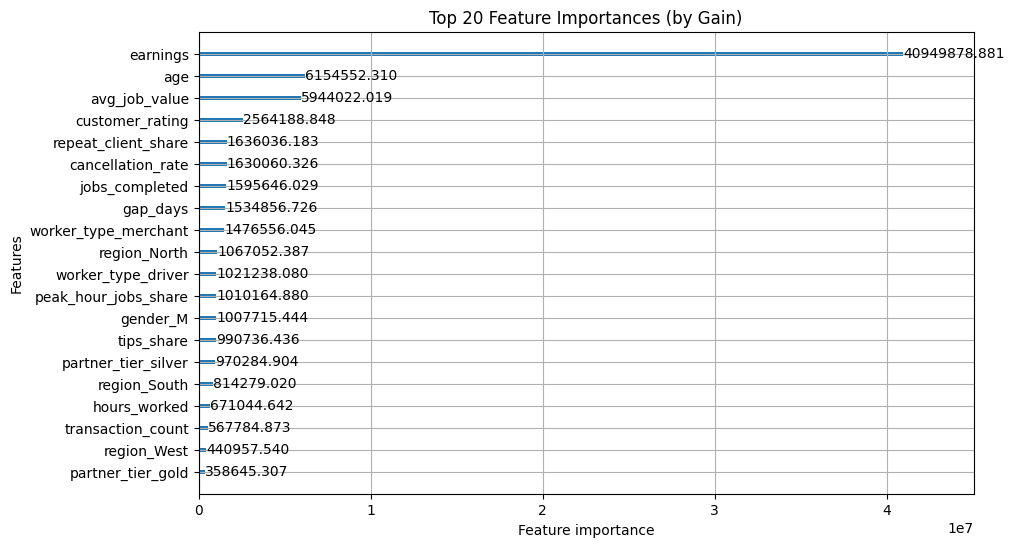

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Plot feature importance
lgb.plot_importance(model, max_num_features=20, importance_type="gain", figsize=(10, 6))
plt.title("Top 20 Feature Importances (by Gain)")
plt.show()


In [14]:
# =============================
# Project Nova - Optimized LightGBM
# =============================

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

# ---------------------------
# 1. Load Dataset
# ---------------------------
df = pd.read_csv("/content/final_nova_dataset_65_35.csv")

# After loading dataset in training script
signup_week_map = df.groupby("worker_id")["week"].min().to_dict()
df["signup_week"] = df["worker_id"].map(signup_week_map)
df["tenure_weeks"] = df["week"] - df["signup_week"]

# Define target and features
y = df["nova_score"]
X = df.drop(columns=["nova_score", "worker_id", "nova_prev_score", "week","age"])

# ---------------------------
# 2. Train/Test Split
# ---------------------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------
# 3. Handle categorical vars directly in LightGBM
# ---------------------------
# Instead of one-hot encoding, let LightGBM handle categorical splits
categorical_cols = X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()
for col in categorical_cols:
    X_train_raw[col] = X_train_raw[col].astype("category")
    X_test_raw[col] = X_test_raw[col].astype("category")

# ---------------------------
# 4. Train LightGBM Model
# ---------------------------
train_data = lgb.Dataset(X_train_raw, label=y_train, categorical_feature=categorical_cols)
valid_data = lgb.Dataset(X_test_raw, label=y_test, reference=train_data, categorical_feature=categorical_cols)

params = {
    "objective": "regression",
    "metric": ["rmse", "r2"],
    "boosting_type": "gbdt",
    "learning_rate": 0.02,         # smaller LR, more boosting rounds
    "num_leaves": 64,              # more complex trees than 31
    "max_depth": -1,
    "lambda_l1": 0.3,              # stronger L1 reg
    "lambda_l2": 0.7,              # balanced L2 reg
    "min_data_in_leaf": 30,        # allow finer splits
    "feature_fraction": 0.9,       # use more features
    "bagging_fraction": 0.9,
    "bagging_freq": 2,
    "min_gain_to_split": 0.01,     # avoid weak splits
    "verbosity": -1
}

print("Training Optimized LightGBM...")
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "eval"],
    num_boost_round=10000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(300)
    ]
)

# ---------------------------
# 5. Model Evaluation
# ---------------------------
y_pred = model.predict(X_test_raw, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nOptimized LightGBM - RMSE: {rmse:.4f}, R²: {r2:.4f}")

# ---------------------------
# 6. Feature Importance
# ---------------------------
importances = pd.DataFrame({
    "feature": X_train_raw.columns,
    "importance": model.feature_importance()
}).sort_values(by="importance", ascending=False)

print("\nTop 15 Feature Importances:")
print(importances.head(20))


Training Optimized LightGBM...
Training until validation scores don't improve for 200 rounds
[300]	train's rmse: 4.23207	eval's rmse: 5.1685
[600]	train's rmse: 3.43408	eval's rmse: 4.94863
[900]	train's rmse: 2.90801	eval's rmse: 4.82793
[1200]	train's rmse: 2.51541	eval's rmse: 4.77163
[1500]	train's rmse: 2.21321	eval's rmse: 4.7335
[1800]	train's rmse: 1.96189	eval's rmse: 4.70944
[2100]	train's rmse: 1.74735	eval's rmse: 4.6892
[2400]	train's rmse: 1.56965	eval's rmse: 4.68043
[2700]	train's rmse: 1.41387	eval's rmse: 4.67204
[3000]	train's rmse: 1.28035	eval's rmse: 4.67118
Early stopping, best iteration is:
[2954]	train's rmse: 1.29886	eval's rmse: 4.66984

Optimized LightGBM - RMSE: 4.6698, R²: 0.8187

Top 15 Feature Importances:
                 feature  importance
17          tenure_weeks       25443
4               earnings       21181
11       customer_rating       17615
7          avg_job_value       16544
12     cancellation_rate       15898
13  peak_hour_jobs_share      

In [12]:
print(importances.head(25))

                 feature  importance
17          tenure_weeks       25443
4               earnings       21181
11       customer_rating       17615
7          avg_job_value       16544
12     cancellation_rate       15898
13  peak_hour_jobs_share       14402
6    repeat_client_share       13877
10            tips_share       13566
8           hours_worked        8286
16           signup_week        7590
14     transaction_count        7257
3            worker_type        5425
5         jobs_completed        4984
2           partner_tier        4459
15              gap_days        3290
0                 gender        3085
1                 region        2972
9          dispute_count         228


In [16]:
# ==============================
# Project Nova - Fair & Optimized LightGBM
# ==============================

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
# 1. Load Dataset
# -----------------------------
df = pd.read_csv("/content/final_nova_dataset_65_35.csv")

# -----------------------------
# 2. Temporal Feature
# -----------------------------
signup_week_map = df.groupby("worker_id")["week"].min().to_dict()
df["signup_week"] = df["worker_id"].map(signup_week_map)
df["tenure_weeks"] = df["week"] - df["signup_week"]

# -----------------------------
# 3. Define Target & Features
# -----------------------------
y = df["nova_score"]

# Keep only performance-based features
performance_features = [
    'earnings','jobs_completed','repeat_client_share','avg_job_value',
    'hours_worked','dispute_count','tips_share','customer_rating',
    'cancellation_rate','peak_hour_jobs_share','transaction_count','gap_days',
    'tenure_weeks'
]

X = df[performance_features]

# -----------------------------
# 4. Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 5. LightGBM Dataset
# -----------------------------
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# -----------------------------
# 6. Train LightGBM
# -----------------------------
params = {
    "objective": "regression",
    "metric": ["rmse", "r2"],
    "boosting_type": "gbdt",
    "learning_rate": 0.02,
    "num_leaves": 64,
    "max_depth": -1,
    "lambda_l1": 0.3,
    "lambda_l2": 0.7,
    "min_data_in_leaf": 30,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 2,
    "min_gain_to_split": 0.01,
    "verbosity": -1
}

print("Training Fair LightGBM...")
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "eval"],
    num_boost_round=10000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(300)
    ]
)

# -----------------------------
# 7. Predict
# -----------------------------
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# -----------------------------
# 8. Fairness Post-processing
# -----------------------------
sensitive_features = ['gender','region','partner_tier','worker_type']

# Adjust predictions so mean per group equals overall mean
overall_mean = np.mean(y_pred)
y_pred_fair = y_pred.copy()

for s in sensitive_features:
    group_means = pd.DataFrame({s: df.loc[X_test.index, s], 'pred': y_pred_fair}).groupby(s)['pred'].mean()
    for grp, grp_mean in group_means.items():
        y_pred_fair[df.loc[X_test.index, s] == grp] += (overall_mean - grp_mean)

# -----------------------------
# 9. Evaluation
# -----------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred_fair))
r2 = r2_score(y_test, y_pred_fair)
print(f"\nFair LightGBM - RMSE: {rmse:.4f}, R²: {r2:.4f}")

# -----------------------------
# 10. Feature Importances
# -----------------------------
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importance()
}).sort_values(by="importance", ascending=False)

print("\nTop Feature Importances:")
print(importances)

# -----------------------------
# 11. Fairness Check
# -----------------------------
for s in sensitive_features:
    print(f"\nMean predicted Nova Score by {s} (after fairness adjustment):")
    print(pd.DataFrame({s: df.loc[X_test.index, s], 'pred': y_pred_fair}).groupby(s).mean())


Training Fair LightGBM...
Training until validation scores don't improve for 200 rounds
[300]	train's rmse: 4.90274	eval's rmse: 6.08511
Early stopping, best iteration is:
[262]	train's rmse: 5.02118	eval's rmse: 6.07943

Fair LightGBM - RMSE: 6.3739, R²: 0.6623

Top Feature Importances:
                 feature  importance
12          tenure_weeks        3897
0               earnings        2572
7        customer_rating        1672
2    repeat_client_share        1432
3          avg_job_value        1392
8      cancellation_rate        1286
9   peak_hour_jobs_share        1021
6             tips_share        1013
4           hours_worked         763
11              gap_days         558
1         jobs_completed         443
10     transaction_count         438
5          dispute_count          19

Mean predicted Nova Score by gender (after fairness adjustment):
             pred
gender           
F       72.372419
M       71.938625
Other   71.056561

Mean predicted Nova Score by region 

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
# 1. Load Dataset
# -----------------------------
df = pd.read_csv("/content/final_nova_dataset_65_35.csv")

# -----------------------------
# 2. Temporal Features
# -----------------------------
signup_week_map = df.groupby("worker_id")["week"].min().to_dict()
df["signup_week"] = df["worker_id"].map(signup_week_map)
df["tenure_weeks"] = df["week"] - df["signup_week"]
df['earnings_x_repeat_client'] = df['earnings'] * df['repeat_client_share']
df['rating_weighted_avg_job'] = df['customer_rating'] * df['avg_job_value']
# -----------------------------
# 3. Create rolling & trend features
# -----------------------------
numeric_features = [
    'earnings','jobs_completed','repeat_client_share','avg_job_value',
    'hours_worked','dispute_count','tips_share','customer_rating',
    'cancellation_rate','peak_hour_jobs_share','transaction_count','gap_days'
]

# Trend = current value - previous value (rolling 3 weeks)
for f in numeric_features:
    # rolling mean
    df[f + "_roll_mean"] = df.groupby("worker_id")[f].transform(lambda x: x.rolling(3, min_periods=1).mean())
    # trend: last - first in rolling window (safer)
    df[f + "_trend"] = df.groupby("worker_id")[f].transform(
        lambda x: x.rolling(3, min_periods=1).apply(lambda y: y.iloc[-1] - y.iloc[0])
    )

# -----------------------------
# 4. Target & features
# -----------------------------
performance_features = []
for f in numeric_features:
    performance_features += [f, f + "_roll_mean", f + "_trend"]
performance_features += ["tenure_weeks"]

X = df[performance_features]
y = df["nova_score"]

# -----------------------------
# 5. Train/Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 6. LightGBM Dataset
# -----------------------------
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# -----------------------------
# 7. Train LightGBM
# -----------------------------
params = {
    "objective": "regression",
    "metric": ["rmse", "r2"],
    "boosting_type": "gbdt",
    "learning_rate": 0.015,      # lower LR for stability
    "num_leaves": 128,           # more complex trees
    "max_depth": -1,
    "lambda_l1": 0.5,            # stronger L1
    "lambda_l2": 0.7,            # L2 for smoothness
    "min_data_in_leaf": 25,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.85,
    "bagging_freq": 2,
    "min_gain_to_split": 0.01,
    "verbose": -1
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "eval"],
    num_boost_round=10000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(300)
    ]
)

# -----------------------------
# 8. Predict
# -----------------------------
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# -----------------------------
# 9. Fairness Post-processing
# -----------------------------
sensitive_features = ['gender','region','partner_tier','worker_type']
overall_mean = np.mean(y_pred)
y_pred_fair = y_pred.copy()

for s in sensitive_features:
    group_means = pd.DataFrame({s: df.loc[X_test.index, s], 'pred': y_pred_fair}).groupby(s)['pred'].mean()
    for grp, grp_mean in group_means.items():
        y_pred_fair[df.loc[X_test.index, s] == grp] += (overall_mean - grp_mean)

# -----------------------------
# 10. Evaluation
# -----------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred_fair))
r2 = r2_score(y_test, y_pred_fair)
print(f"\nFair LightGBM - RMSE: {rmse:.4f}, R²: {r2:.4f}")

# -----------------------------
# 11. Feature Importance
# -----------------------------
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": model.feature_importance()
}).sort_values(by="importance", ascending=False)

print("\nTop Feature Importances:")
print(importances.head(20))


Training until validation scores don't improve for 200 rounds
[300]	train's rmse: 3.77169	eval's rmse: 5.56754
[600]	train's rmse: 2.64804	eval's rmse: 5.50315
[900]	train's rmse: 2.00673	eval's rmse: 5.49489
[1200]	train's rmse: 1.56459	eval's rmse: 5.49005
[1500]	train's rmse: 1.23489	eval's rmse: 5.4882
Early stopping, best iteration is:
[1502]	train's rmse: 1.23318	eval's rmse: 5.48794

Fair LightGBM - RMSE: 5.8743, R²: 0.7131

Top Feature Importances:
                           feature  importance
36                    tenure_weeks       21433
22       customer_rating_roll_mean        7883
10         avg_job_value_roll_mean        7297
1               earnings_roll_mean        7268
25     cancellation_rate_roll_mean        7228
7    repeat_client_share_roll_mean        7225
28  peak_hour_jobs_share_roll_mean        7093
2                   earnings_trend        6972
23           customer_rating_trend        6599
19            tips_share_roll_mean        6557
26         cancellatio

In [3]:
import joblib

# Save LightGBM model
joblib.dump(model, "/content/lightgbm_model.pkl")  # 'model' is your trained LightGBM

# Download to local
from google.colab import files
files.download("/content/lightgbm_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1. Load new CSV
# -----------------------------
df = pd.read_csv("/content/final_nova_dataset_65_35.csv")

# -----------------------------
# 2. Temporal features
# -----------------------------
signup_week_map = df.groupby("worker_id")["week"].min().to_dict()
df["signup_week"] = df["worker_id"].map(signup_week_map)
df["tenure_weeks"] = df["week"] - df["signup_week"]
df['earnings_x_repeat_client'] = df['earnings'] * df['repeat_client_share']
df['rating_weighted_avg_job'] = df['customer_rating'] * df['avg_job_value']

# -----------------------------
# 3. Rolling & trend features
# -----------------------------
numeric_features = [
    'earnings','jobs_completed','repeat_client_share','avg_job_value',
    'hours_worked','dispute_count','tips_share','customer_rating',
    'cancellation_rate','peak_hour_jobs_share','transaction_count','gap_days'
]

window = 3
for f in numeric_features:
    # rolling mean
    df[f + "_roll_mean"] = df.groupby("worker_id")[f].transform(lambda x: x.rolling(window, min_periods=1).mean())
    # trend = last - first in rolling window
    df[f + "_trend"] = df.groupby("worker_id")[f].transform(lambda x: x.rolling(window, min_periods=1).apply(lambda y: y.iloc[-1] - y.iloc[0]))

# -----------------------------
# 4. Interaction features (if used in training)
# -----------------------------
df['earnings_per_job'] = df['earnings'] / (df['jobs_completed'] + 1e-6)
df['tips_quality'] = df['tips_share'] * df['customer_rating']
df['value_loyalty'] = df['avg_job_value'] * df['repeat_client_share']

# -----------------------------
# 5. Prepare model features
# -----------------------------
all_features = numeric_features + \
               [f+'_roll_mean' for f in numeric_features] + \
               [f+'_trend' for f in numeric_features] + \
               ['tenure_weeks']

X_lgb = df[all_features]

# -----------------------------
# 6. Load trained LightGBM model
# -----------------------------
lgb_model = joblib.load("/content/lightgbm_model.pkl")  # or joblib.load if saved that way

# -----------------------------
# 7. Predict
# -----------------------------
y_lgb_pred = lgb_model.predict(X_lgb)

# -----------------------------
# 8. Fairness adjustment
# -----------------------------
sensitive_features = ['gender','region','partner_tier','worker_type']
overall_mean = np.mean(y_lgb_pred)
y_lgb_fair = y_lgb_pred.copy()

for s in sensitive_features:
    group_means = pd.DataFrame({s: df[s], 'pred': y_lgb_fair}).groupby(s)['pred'].mean()
    for grp, grp_mean in group_means.items():
        y_lgb_fair[df[s] == grp] += (overall_mean - grp_mean)

df['nova_score_lightgbm'] = y_lgb_fair

# -----------------------------
# 9. Save CSV with predictions
# -----------------------------
df.to_csv("nova_scores_with_lgb.csv", index=False)
print("✅ Predictions added and CSV saved as 'nova_scores_with_lgb.csv'")


✅ Predictions added and CSV saved as 'nova_scores_with_lgb.csv'


In [18]:
print(df.head())

   worker_id  week  age gender region partner_tier worker_type  earnings  \
0          0     4   33      M  North       silver    merchant   1416.67   
1          0     5   33      M  North       silver    merchant   1486.81   
2          0     6   33      M  North       silver    merchant   1608.10   
3          0     7   33      M  North       silver    merchant   1498.12   
4          0     8   33      M  North       silver    merchant   1779.19   

   jobs_completed  repeat_client_share  ...  peak_hour_jobs_share_roll_mean  \
0               7                 0.93  ...                        0.680000   
1              12                 0.39  ...                        0.530000   
2              14                 0.22  ...                        0.466667   
3               8                 0.18  ...                        0.413333   
4              11                 0.37  ...                        0.400000   

   peak_hour_jobs_share_trend  transaction_count_roll_mean  \
0     